In [197]:
from memory_profiler import memory_usage
import time
from collections.abc import Callable
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
class GA:
    def __init__(
        self,
        fitness: Callable,
        num_individuals: int,
        num_genes: int,
        num_generations: int,
        tournament_size: int,
        mutation_rate: float,
    ) -> None:
        self.fitness = fitness
        self.rng = np.random.default_rng()
        self.num_individuals = num_individuals
        self.num_genes = num_genes
        self.num_generations = num_generations
        self.tournament_size = tournament_size
        self.mutation_rate = mutation_rate
        self.num_evaluations = 0

    def initialize(self) -> None:
        self.population = [
            [int(self.rng.integers(0, 2)) for _ in range(self.num_genes)]
            for _ in range(self.num_individuals)
        ]

    def evaluation(self, individual: list) -> float:
        return self.fitness(individual)

    def selection(self, tournament_size: int) -> list:
        tournament_winners = []
        for _ in range(self.num_individuals):
            tournament_contestants = self.rng.choice(len(self.population), tournament_size, replace=False)
            tournament_contestants = [self.population[i] for i in tournament_contestants]
            contestants_fitness = []
            for individual in tournament_contestants:
                individual_fitness = self.evaluation(individual)
                self.num_evaluations += 1
                contestants_fitness.append((individual, individual_fitness))
            contestants_fitness.sort(
                key=lambda x: x[1],
                reverse=True,
            )
            tournament_winners.append(contestants_fitness[0][0])
        return tournament_winners

    def crossover(self, selected_parents: list) -> list:
        cut_point = self.rng.integers(1, self.num_genes)

        offspring = []
        for i in range(0, len(selected_parents), 2):
            parent1 = selected_parents[i]
            parent2 = selected_parents[(i + 1) % len(selected_parents)]
            child1 = list(parent1[:cut_point]) + list(parent2[cut_point:])
            child2 = list(parent2[:cut_point]) + list(parent1[cut_point:])
            offspring.append(child1)
            offspring.append(child2)
        return offspring[: self.num_individuals]

    def mutation(self, population: list, mutation_rate: float) -> list:
        mutated_population = []
        for individual in population:
            child = individual.copy()
            mutation_chance = self.rng.random(len(individual))
            for i, rate in enumerate(mutation_chance):
                if rate < mutation_rate:
                    child[i] = 1 - child[i]
            mutated_population.append(child)
        return mutated_population

    def substitute_population(self, population: list) -> None:
        self.population = population

    def optimize(self) -> tuple[list[int], float]:
        self.initialize()

        for _ in range(self.num_generations):
            selected_parents = self.selection(self.tournament_size)
            childs = self.crossover(selected_parents)
            new_population = self.mutation(childs, self.mutation_rate)
            self.substitute_population(new_population)

        best_solution = max(self.population, key=self.evaluation)
        best_fitness = self.evaluation(best_solution)

        return best_solution, best_fitness

In [199]:
with open("../data/knapsack_instance.txt") as f:
    lines = f.read().strip().split("\n")

    max_capacity = int(lines[1])
    utility_vector = []
    weight_vector = []

    for line in lines[2:]:
        utility, weight = map(int, line.split())
        utility_vector.append(utility)
        weight_vector.append(weight)

In [200]:
def knapsack(binary_vector: list) -> float:
    fitness = 0
    capacity = 0

    for binary, weight, utility in zip(binary_vector, weight_vector, utility_vector, strict=True):
        fitness += binary * utility
        capacity += binary * weight

    if capacity <= max_capacity:
        return fitness
    return fitness - 10 * (capacity - max_capacity)

In [201]:
NUM_INDIVIDUALS = 200
NUM_GENES = 100
NUM_GENERATIONS = 50
TOURNAMENT_SIZE = 2
MUTATION_RATE = 0.2

In [202]:
fitness_history = []
time_history = []
memory_history = []

In [203]:
for i in range(20):
    def rodar_ga():
        ga = GA(knapsack, NUM_INDIVIDUALS, NUM_GENES, NUM_GENERATIONS, TOURNAMENT_SIZE, MUTATION_RATE)
        best_solution, best_fitness = ga.optimize()
        return ga, best_solution, best_fitness

    start = time.time()
    mem_usage, (ga, best_solution, best_fitness) = memory_usage(
        (rodar_ga,), retval=True, max_usage=True,
    )
    end = time.time()

    fitness_history.append(best_fitness)
    time_history.append(end - start)
    memory_history.append(mem_usage)

In [204]:
def visualize(df, feature):
    plt.figure(figsize=(10, 4))
    sns.lineplot(data=df, x="Run", y=feature)
    plt.xticks(range(1, 21))
    plt.axhline(df[feature].mean(), ls="--", c="orange", label=f"Average = {df[feature].mean():.2f}")
    plt.xlabel("Run")
    plt.ylabel(feature)
    plt.legend()
    plt.show()

In [205]:
df = pd.DataFrame({
    "Run": range(1, 21),
    "Fitness": fitness_history,
    "Time (s)": time_history,
    "Memory (MiB)": memory_history,
})

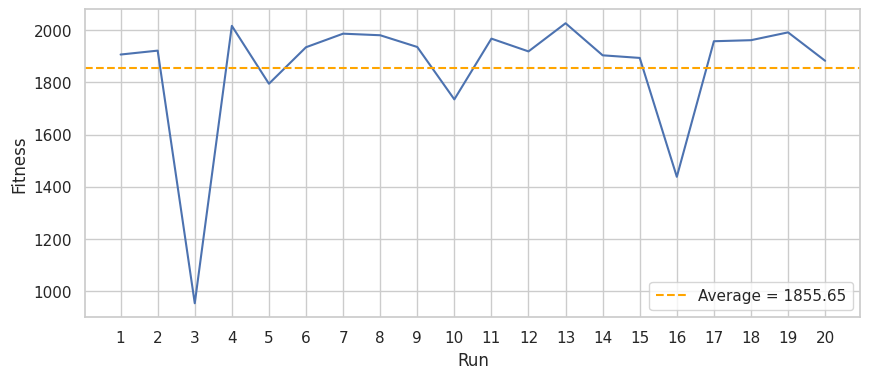

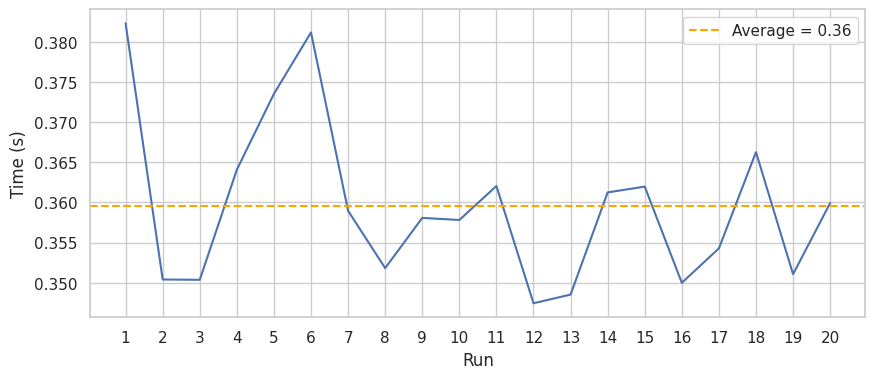

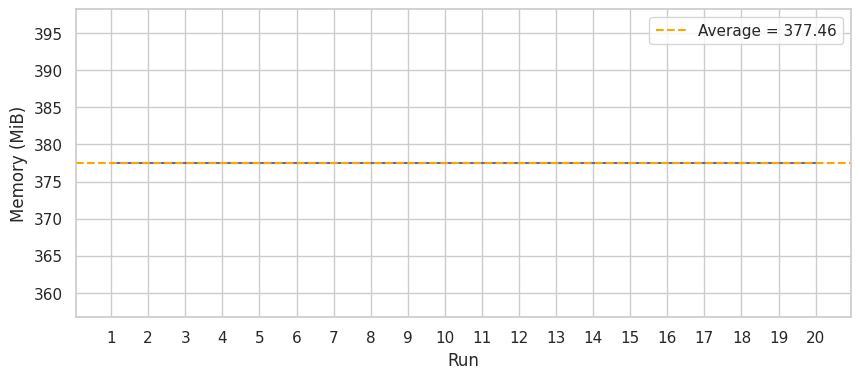

In [206]:
for feature in df.columns[1:]:
    visualize(df, feature)